### Runnning inference and methods that measure the uncertainty (post training)
For inference we need
1. Load the model
2. Load data
3. Visulize, lets see what is out there for NuScenes

In [1]:
import os, sys
sys.path.insert(0, "/home/image/ohs/Det3D")
import torch

import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import nuscenes
from nuscenes.nuscenes import NuScenes

# Importing from Det3D
from det3d.torchie import Config
from det3d.datasets import build_dataset, build_dataloader
from det3d.torchie.trainer.trainer import example_to_device

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # single GPU

In [33]:
#file_path="/home/image/ohs/Det3D/examples/cbgs/configs/inference_uncertainty_config.py"
file_path ="/home/image/ohs/Det3D/examples/cbgs/configs/nusc_all_vfev3_spmiddleresnetfhd_rpn2_mghead_syncbn.py"
cfg = Config.fromfile(file_path)


In [4]:
nusc_val_dataset = build_dataset(cfg.data.val)
nusc_val_loader =  build_dataloader(nusc_val_dataset, 2,1, dist=False)
nusc = NuScenes(version=nusc_val_dataset.version, dataroot=str(nusc_val_dataset._root_path), verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 44.9 seconds.
Reverse indexing ...
Done reverse indexing in 13.9 seconds.


In [5]:
A = next(iter(nusc_val_loader))
example = example_to_device(A, torch.cuda.current_device(), non_blocking=False)

In [6]:
# ego_pose contains information about the location (encoded in translation) and the orientation (encoded in rotation) 
# of the ego vehicle body frame, with respect to the global coordinate system.
print(len(nusc.ego_pose), len(nusc.sample_data))
nusc.ego_pose[0].keys()

2631083 2631083


dict_keys(['token', 'timestamp', 'rotation', 'translation'])

In [7]:
sample = nusc.sample[20]
print(sample.keys())
print(sample['data'])
print(nusc.get('sample_data', sample['data']['LIDAR_TOP'])['is_key_frame'])
print(nusc.get('sample_data', nusc.get('sample', sample['next'])['data']['LIDAR_TOP'])['is_key_frame'])

dict_keys(['token', 'timestamp', 'prev', 'next', 'scene_token', 'data', 'anns'])
{'RADAR_FRONT': '516bfb53b8ca4eab8f0401471722932a', 'RADAR_FRONT_LEFT': 'ee90f17b44aa479d811006ca70f56180', 'RADAR_FRONT_RIGHT': '9a99ce3c845146bd93b80489e51291c2', 'RADAR_BACK_LEFT': 'f1f918b57e0b441c9a41a2e7d2b9b72d', 'RADAR_BACK_RIGHT': '5e21742e01484635bacb0b5de9f3dac2', 'LIDAR_TOP': '946b839480be46a3ae1ddcb359079f6d', 'CAM_FRONT': 'a59c061fc9b7488693b91d0bab13acf1', 'CAM_FRONT_RIGHT': '5a331ab3acfb420ebf3c7f7700690f68', 'CAM_BACK_RIGHT': '8fa9938924be4f9d9788e74eb0e51b59', 'CAM_BACK': 'c3dd2544a7624f6d80aba31be6b92226', 'CAM_BACK_LEFT': 'c792b2920d024582b4640f6447bb7a98', 'CAM_FRONT_LEFT': '3e8218fd5e23498b8b11d65d2d34f15a'}
True
True


In [8]:
print(len(nusc.sample_data)) # 2631083 / 34149
print(nusc.sample_data[0].keys())
len(nusc.field2token("sample_data", "sample_token", sample['token']))

2631083
dict_keys(['token', 'sample_token', 'ego_pose_token', 'calibrated_sensor_token', 'timestamp', 'fileformat', 'is_key_frame', 'height', 'width', 'filename', 'prev', 'next', 'sensor_modality', 'channel'])


80

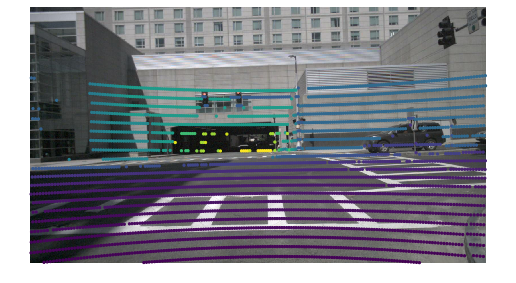

In [9]:
nusc.render_pointcloud_in_image(example['metadata'][0]['token'], pointsensor_channel='LIDAR_TOP')
# nusc.render_pointcloud_in_image(sample['token'], pointsensor_channel='LIDAR_TOP')

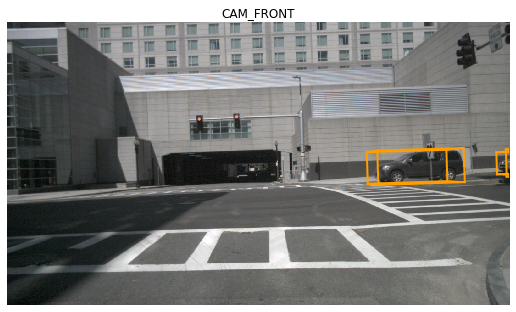

In [10]:
sample = nusc.get('sample', example['metadata'][0]['token'])
nusc.render_sample_data(sample['data']['CAM_FRONT'])

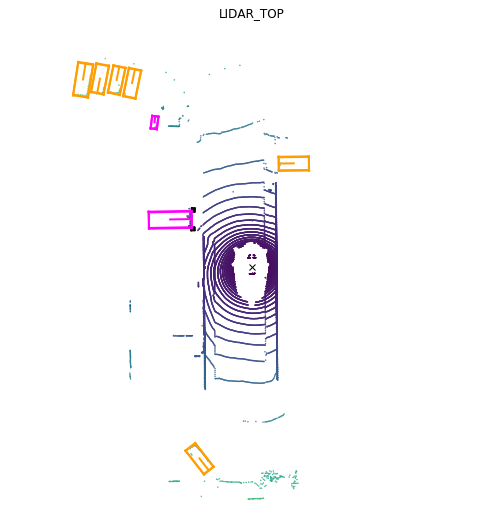

In [36]:
nusc.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=1)

In [37]:
print(example['metadata'][0]['token'])

13ade121714c46d6a028516ecb5bff60


In [38]:
token = sample['data']['LIDAR_TOP']
A = nusc.get('sample_data', token)
nusc.get('ego_pose', A['ego_pose_token'])['translation']

[2312.052872978604, 1038.2634891451582, 0.0]

In [39]:
print('example translation:', example['annos'][0]['boxes'][0])
ego_pose_translation = np.asarray(nusc.get('ego_pose', A['ego_pose_token'])['translation'])
sample_translation = np.asarray(nusc.get('sample_annotation', sample['anns'][0])['translation'])
print('sample translation', sample_translation - ego_pose_translation)

example translation: [-1.5908033e+01  2.3654100e+01  2.0628026e-02  1.0340000e+00
  2.0490000e+00  1.2610000e+00 -5.3575584e-03 -4.2898547e-02
 -3.0194871e+00]
sample translation [-16.12687298  24.48251085   0.548     ]


In [40]:
example['annos'][0]['boxes'][0]

array([-1.5908033e+01,  2.3654100e+01,  2.0628026e-02,  1.0340000e+00,
        2.0490000e+00,  1.2610000e+00, -5.3575584e-03, -4.2898547e-02,
       -3.0194871e+00], dtype=float32)

In [34]:
from det3d.models import build_detector
from det3d.torchie.trainer.checkpoint import load_checkpoint

model_file = '/home/image/ohs/Det3D/experiments/hpc_experiments/baselines/cbgs/resnet/epoch_10.pth'

model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
loaded_model = load_checkpoint(model, model_file)


In [35]:
model = loaded_model
model.eval()
mode = "val" # need to load a dectetor from a checkpoint

AttributeError: 'dict' object has no attribute 'eval'

In [26]:
example = next(iter(nusc_val_loader))

In [27]:
predictions = model(example,return_loss=False)

In [28]:
type(predictions)

list

In [ ]:
from det3d.datasets.nuscenes.common.

In [30]:
predictions[0]['box3d_lidar'].shape

torch.Size([80, 9])

In [32]:
predictions[0]['scores']

tensor([0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070,
        0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070, 0.5070],
       grad_fn=<CatBackward>)